In [1]:
import torch
import torchvision

import torch.nn.functional as F
import torch.nn as nn

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from PIL import Image

import matplotlib.pyplot as plt
import numpy as np

import os
import random
import json

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Modelo

In [3]:
class Tokenizer(nn.Module):
    def __init__(self):
        super(Tokenizer, self).__init__()


        self.add_module("Conv_Layers",
          nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding = 1),

                nn.Conv2d(64, 256, kernel_size=7, stride=2, padding=3, bias=False),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3, stride=2, padding = 1)
          )
        )

        self.flattener = nn.Flatten(2, 3)

    def sequence_length(self, n_channels=3, height=224, width=224):
        return self.forward(torch.zeros((1, n_channels, height, width))).shape[1]

    def forward(self, x):
        return self.flattener(self.Conv_Layers(x)).transpose(-2, -1)


class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads=8): # dim = 256
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // self.num_heads #d
        self.scale = head_dim ** 0.5

        self.q_fc = nn.Linear(dim, dim)
        self.k_fc = nn.Linear(dim, dim)
        self.v_fc = nn.Linear(dim, dim)

        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape #B = BATCH_SIZE(64), N = N_KERNELS(256), C = flatten(mapa_caracteristicas)(16x16 = 256)

        q = self.q_fc(x).reshape((B, self.num_heads, N, C // self.num_heads))
        k = self.k_fc(x).reshape((B, self.num_heads, N, C // self.num_heads))
        v = self.v_fc(x).reshape((B, self.num_heads, N, C // self.num_heads))
        #                        64          4       256            64

        attn = (q @ k.transpose(-2, -1)) / self.scale
        #  q.shape  =  64    4      256      64
        #  k.shape  =  64    4       64     256
        attn = attn.softmax(dim=-1)
        #   64     4      256      256

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        #   transpose     =  64   256      4    256
        #   reshape       =  64   256     1024
        out = self.proj(out)
        #   out  =   256
        return out


class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048):

        super(TransformerEncoderLayer, self).__init__()

        self.pre_norm = nn.LayerNorm(d_model)
        self.self_attn = MultiHeadAttention(dim=d_model, num_heads=nhead)


        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.norm1 = nn.LayerNorm(d_model)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.activation = F.gelu

    def forward(self, x):
        mha = self.self_attn(self.pre_norm(x))
        out = x + mha
        out = self.norm1(out)

        out2 = self.linear2(self.activation(self.linear1(out)))
        out = out + out2
        return out


class TransformerClassifier(nn.Module):
    def __init__(self,
                 embedding_dim,
                 num_layers,
                 num_heads,
                 num_classes,
                 sequence_length): #Tokenizer

        super().__init__()

        dim_feedforward = int(embedding_dim * 3)
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.num_tokens = 0

        self.sequence_pooling = nn.Linear(self.embedding_dim, 1)


        #Positional Embedding
        self.positional_emb = nn.Parameter(torch.zeros(1, sequence_length, embedding_dim),
                                                requires_grad=True)
        nn.init.trunc_normal_(self.positional_emb, std=0.2)

        #Transformer Encoder Blocks
        self.blocks = nn.ModuleList([
            TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads,
                                    dim_feedforward=dim_feedforward)

            for i in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embedding_dim)

        #Clasificador
        self.fc = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        x = x + self.positional_emb

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        #sequence pooling
        x = torch.matmul(F.softmax(self.sequence_pooling(x), dim=1).transpose(-1, -2), x).squeeze(-2)

        x = self.fc(x)
        return x


class CCT(nn.Module):
    def __init__(self,
                 img_size=506,
                 embedding_dim=256,
                 num_layers=6, #14
                 num_heads=4, #6
                 num_classes=292,
                 *args, **kwargs):
        super(CCT, self).__init__()

        self.tokenizer = Tokenizer()

        self.classifier = TransformerClassifier(
            sequence_length=self.tokenizer.sequence_length(n_channels=3,
                                                           height=img_size,
                                                           width=img_size),
            embedding_dim=embedding_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            num_classes=num_classes,
        )

    def forward(self, x):
        x = self.tokenizer(x)
        return self.classifier(x)

In [4]:
PATH = "app/CCT_model_1.pth"
device = torch.device("cuda")
model = CCT()
model.load_state_dict(torch.load(PATH))
model.to(device)
model.eval()

CCT(
  (tokenizer): Tokenizer(
    (Conv_Layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 256, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (4): ReLU()
      (5): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (flattener): Flatten(start_dim=2, end_dim=3)
  )
  (classifier): TransformerClassifier(
    (sequence_pooling): Linear(in_features=256, out_features=1, bias=True)
    (blocks): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (pre_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attn): MultiHeadAttention(
          (q_fc): Linear(in_features=256, out_features=256, bias=True)
          (k_fc): Linear(in_features=256, out_features=256, bias=True)
          (v_fc): Linear(in_features=256, out_features

# Prueba

In [5]:
names = ['Lactuca virosa L.', "Pelargonium graveolens L'Hér.", 'Cirsium arvense (L.) Scop.', 'Cirsium vulgare (Savi) Ten.', "Pelargonium peltatum (L.) L'Hér.", "Pelargonium zonale (L.) L'Hér.", 'Mercurialis annua L.', 'Hypericum perforatum L.', 'Tradescantia fluminensis Vell.', 'Lamium amplexicaule L.', 'Lavandula dentata L.', 'Melilotus albus Medik.', 'Trifolium fragiferum L.', 'Dryopteris filix-mas (L.) Schott', 'Nephrolepis cordifolia (L.) C. Presl', 'Nephrolepis exaltata (L.) Schott', 'Osmunda regalis L.', 'Lithodora fruticosa (L.) Griseb.', 'Humulus lupulus L.', 'Vaccaria hispanica (Mill.) Rauschert', 'Calendula officinalis L.', 'Carthamus lanatus L.', 'Helminthotheca echioides (L.) Holub', 'Hyoseris radiata L.', 'Lactuca muralis (L.) Gaertn.', 'Limbarda crithmoides (L.) Dumort.', 'Sedum acre L.', 'Sedum album L.', 'Sedum dasyphyllum L.', 'Sedum forsterianum Sm.', 'Sedum sediforme (Jacq.) Pau', 'Alliaria petiolata (M. Bieb.) Cavara & Grande', 'Acalypha virginica L.', 'Mercurialis perennis L.', 'Hypericum androsaemum L.', 'Hypericum hircinum L.', 'Hypericum hirsutum L.', 'Hypericum humifusum L.', 'Hypericum tetrapterum Fr.', 'Lamium hybridum Vill.', 'Lamium purpureum L.', 'Lavandula stoechas L.', 'Galega officinalis L.', 'Trifolium angustifolium L.', 'Trifolium arvense L.', 'Trifolium aureum Pollich', 'Trifolium campestre Schreb.', 'Trifolium hybridum L.', 'Trifolium incarnatum L.', 'Trifolium montanum L.', 'Trifolium pratense L.', 'Trifolium resupinatum L.', 'Trifolium stellatum L.', 'Punica granatum L.', 'Alcea rosea L.', 'Althaea cannabina L.', 'Althaea officinalis L.', 'Nymphaea alba L.', 'Adonis annua L.', 'Anemone coronaria L.', 'Hyoscyamus albus L.', 'Hyoscyamus niger L.', 'Daphne gnidium L.', 'Daphne laureola L.', 'Chaerophyllum temulum L.', 'Meum athamanticum Jacq.', 'Thapsia villosa L.', 'Centranthus calcitrapae (L.) Dufr.', 'Pancratium maritimum L.', 'Anthericum liliago L.', 'Butomus umbellatus L.', 'Oncostema peruviana (L.) Speta', 'Ophrys apifera Huds.', 'Ophrys fusca Link', 'Ophrys lutea Cav.', 'Ophrys scolopax Cav.', 'Ophrys speculum Link', 'Ophrys tenthredinifera Willd.', 'Myosoton aquaticum (L.) Moench', 'Cirsium palustre (L.) Scop.', 'Lamium galeobdolon (L.) L.', 'Lavandula angustifolia Mill.', 'Casuarina cunninghamiana Miq.', 'Trifolium rubens L.', 'Falcaria vulgaris Bernh.', 'Epipactis helleborine (L.) Crantz', 'Centranthus angustifolius (Mill.) DC.', 'Sedum anglicum Huds.', 'Sedum rupestre L.', 'Ophrys insectifera L.', 'Freesia refracta (Jacq.) Klatt', 'Tradescantia pallida (Rose) D.R. Hunt', 'Schefflera actinophylla (Endl.) Harms', 'Cenchrus setaceus (Forssk.) Morrone', 'Anemone hortensis L.', 'Papaver argemone L.', 'Papaver hybridum L.', 'Papaver rhoeas L.', 'Papaver dubium L.', 'Papaver somniferum L.', 'Daucus carota L.', 'Smilax aspera L.', 'Secale cereale L.', 'Phalaris arundinacea L.', 'Sedum hispanicum L.', 'Lupinus angustifolius L.', 'Trifolium dubium Sibth.', 'Trifolium repens L.', 'Melilotus indicus (L.) All.', 'Melilotus officinalis (L.) Pall.', 'Acacia dealbata Link', 'Acacia longifolia (Andrews) Willd.', 'Acacia mearnsii De Wild.', 'Acacia retinodes Schltdl.', 'Barbarea verna (Mill.) Asch.', 'Fragaria vesca L.', 'Duchesnea indica (Jacks.) Focke', 'Centranthus ruber (L.) DC.', 'Tagetes patula L.', 'Lapsana communis L.', 'Carthamus tinctorius L.', 'Lactuca sativa L.', 'Lactuca serriola L.', 'Lupinus polyphyllus Lindl.', 'Trachelospermum jasminoides (Lindl.) Lem.', 'Tradescantia spathacea Sw.', 'Mussaenda erythrophylla Schumach. & Thonn.', 'Morinda citrifolia L.', 'Tagetes erecta L.', 'Peperomia pellucida (L.) Kunth', 'Cucurbita pepo L.', 'Lagenaria siceraria (Molina) Standl.', 'Couroupita guianensis Aubl.', 'Zamioculcas zamiifolia (Lodd.) Engl.', 'Lactuca plumieri (L.) Gren. & Godr.', "Phedimus aizoon (L.) 't Hart", "Phedimus spurius (M.Bieb) 't Hart", 'Cereus jamacaru DC.', 'Sedum pachyphyllum Rose', 'Atocion rupestre (L.) B.Oxelman', 'Aegopodium podagraria L.', 'Erechtites hieraciifolius (L.) Raf. ex DC.', 'Calendula arvensis L.', 'Chaerophyllum hirsutum L.', 'Cirsium eriophorum (L.) Scop.', 'Cirsium erisithales (Jacq.) Scop.', 'Cirsium heterophyllum (L.) Hill', 'Cirsium oleraceum (L.) Scop.', 'Cirsium rivulare (Jacq.) All.', 'Cucurbita maxima Duchesne', 'Cytinus hypocistis (L.) L.', 'Daphne cneorum L.', 'Daphne mezereum L.', 'Dryas octopetala L.', 'Empetrum nigrum L.', 'Epipactis atrorubens (Hoffm.) Besser', 'Epipactis palustris (L.) Crantz', 'Erucastrum incanum (L.) W.D.J.Koch', 'Alliaria petiolata (M.Bieb.) Cavara & Grande', 'Gomphocarpus physocarpus E.Mey.', 'Hebe salicifolia (G.Forst.) Pennell', 'Hippophae rhamnoides L.', 'Hypericum calycinum L.', 'Hypericum maculatum Crantz', 'Kniphofia uvaria (L.) Hook.', 'Lactuca alpina (L.) Benth. & Hook.f.', 'Lactuca viminea (L.) J.Presl & C.Presl', 'Lamium album L.', 'Lamium maculatum (L.) L.', 'Lathraea clandestina L.', 'Lathraea squamaria L.', 'Lavandula latifolia Medik.', 'Liriodendron tulipifera L.', 'Lupinus arboreus Sims', 'Maianthemum bifolium (L.) F.W.Schmidt', 'Melilotus officinalis (L.) Lam.', 'Moehringia ciliata (Scop.) Dalla Torre', 'Narthecium ossifragum (L.) Huds.', 'Neotinea ustulata (L.) R.M.Bateman, Pridgeon & M.W.Chase', 'Ophrys aranifera Huds.', 'Ophrys bertolonii Moretti', 'Ophrys fuciflora (F.W.Schmidt) Moench', 'Ophrys passionis Sennen', 'Anemone alpina L.', 'Anemone apennina L.', 'Papaver alpinum L.', 'Papaver orientale L.', 'Anemone hepatica L.', 'Pelargonium x hybridum (L.) Aiton', 'Pelargonium inquinans (L.) Aiton', 'Anemone nemorosa L.', 'Anemone pulsatilla L.', 'Anemone sylvestris L.', 'Anemone vernalis L.', 'Angelica sylvestris L.', 'Anthericum ramosum L.', 'Pyracantha coccinea M.Roem.', 'Holodiscus discolor (Pursh) Maxim.', 'Diascia rigescens E.Mey. ex Benth.', 'Sedum sarmentosum Bunge', 'Sedum kamtschaticum Fisch. & C.A.Mey.', 'Sedum sexangulare L.', 'Metasequoia glyptostroboides Hu & W.C.Cheng', 'Telekia speciosa (Schreb.) Baumg.', 'Tradescantia virginiana L.', 'Trifolium alpestre L.', 'Trifolium alpinum L.', 'Viscaria vulgaris Bernh.', 'Anemone hupehensis (Lemoine) Lemoine', 'Adenostyles alpina (L.) Bluff & Fingerh.', 'Anemone narcissiflora L.', 'Anemone ranunculoides L.', 'Angelica archangelica L.', 'Cirsium acaulon (L.) Scop.', 'Cirsium spinosissimum (L.) Scop.', 'Cymbalaria muralis P.Gaertn., B.Mey. & Scherb.', 'Fragaria viridis Weston', 'Honckenya peploides (L.) Ehrh.', 'Lactuca perennis L.', 'Trifolium medium L.', 'Trifolium badium Schreb.', 'Freesia alba (G.L.Mey.) Grumbleton', 'Neotinea tridentata (Scop.) R.M.Bateman, Pridgeon & M.W.Chase', 'Adenostyles alliariae (Gouan) A.Kern.', 'Sedum palmeri S.Watson', 'Tradescantia zebrina Bosse', 'Calycanthus floridus L.', 'Anemone blanda Schott & Kotschy', 'Clethra alnifolia L.', 'Hypericum patulum Thunb.', 'Hypericum x hidcoteense Hilling ex Geerinck', 'Smilax rotundifolia L.', 'Perovskia atriplicifolia Benth.', 'Cucurbita moschata Duchesne', 'Schefflera actinophylla Harms', 'Adonis vernalis L.', 'Barbarea vulgaris R.Br.', 'Nephrolepis biserrata (Sw.) Schott', 'Peperomia magnoliifolia (Jacq.) A.Dietr.', 'Peperomia obtusifolia (L.) A.Dietr.', 'Peperomia serpens (Sw.) Loudon', 'Cereus hexagonus (L.) Mill.', 'Asystasia gangetica (L.) T.Anderson', 'Acalypha wilkesiana Müll.Arg.', 'Breynia disticha J.R.Forst. & G.Forst.', 'Alocasia cucullata (Lour.) G.Don', 'Alocasia macrorrhizos (L.) G.Don', 'Acalypha hispida Burm.f.', 'Tradescantia pallida (Rose) D.R.Hunt', 'Schefflera arboricola (Hayata) Merr.', 'Aphelandra squarrosa Nees', 'Gynura aurantiaca (Blume) Sch.Bip. ex DC.', 'Peperomia caperata Yunck.', 'Peperomia obtusifolia (L.) A. Dietr.', 'Anthurium andraeanum Linden ex André', 'Dendrobium nobile Lindl.', 'Nandina domestica Thunb.', 'Conoclinium coelestinum (L.) DC.', 'Duchesnea indica (Andrews) Teschem.', 'Anemone canadensis L.', 'Lamium maculatum L.', 'Maianthemum canadense Desf.', 'Maianthemum racemosum (L.) Link', 'Mertensia virginica (L.) Pers. ex Link', 'Aralia nudicaulis L.', 'Sedum spathulifolium Hook.', 'Tradescantia ohiensis Raf.', 'Lithops pseudotruncatella N.E.Br.', 'Fittonia albivenis (Lindl. ex Veitch) Brummitt', 'Sedum morganianum E.Walther', 'Pelargonium x hortorum L.H. Bailey', 'Loropetalum chinense (R. Br.) Oliv.', 'Liriope muscari (Decne.) L.H.Bailey', 'Peperomia argyreia (Hook.f.) E.Morren', 'Mussaenda philippica A.Rich.', 'Alocasia sanderiana W.Bull', 'Kniphofia uvaria (L.) Oken', 'Sedum palmeri S. Watson', 'Tradescantia zebrina hort. ex Bosse', 'Calendula arvensis M.Bieb.', "Pelargonium zonale (L.) L'Hér. ex Aiton", 'Smilax bona-nox L.', 'Pilosocereus pachycladus F. Ritter', 'Selenicereus anthonyanus (Alexander) D.R. Hunt', 'Tradescantia sillamontana Matuda', 'Cirsium palustre (L.) Coss. ex Scop.', 'Sedum adolphii Raym.-Hamet', 'Sedum burrito Moran', 'Sedum clavatum R.T. Clausen', 'Sedum nussbaumerianum Bitter', 'Sedum rubrotinctum R.T. Clausen', 'Fragaria × ananassa (Duchesne ex Weston) Duchesne ex Rozier']

In [13]:
import serial
!python3 -m serial.tools.list_ports

/dev/ttyACM0        
1 ports found


In [14]:
data_dir = "app/static/uploads/"
images = os.listdir(data_dir)
model = model.to(device)

transform = transforms.Compose([
    transforms.Resize(size = (506,506)),
    transforms.ToTensor()
])

['Tagetes patula L.']


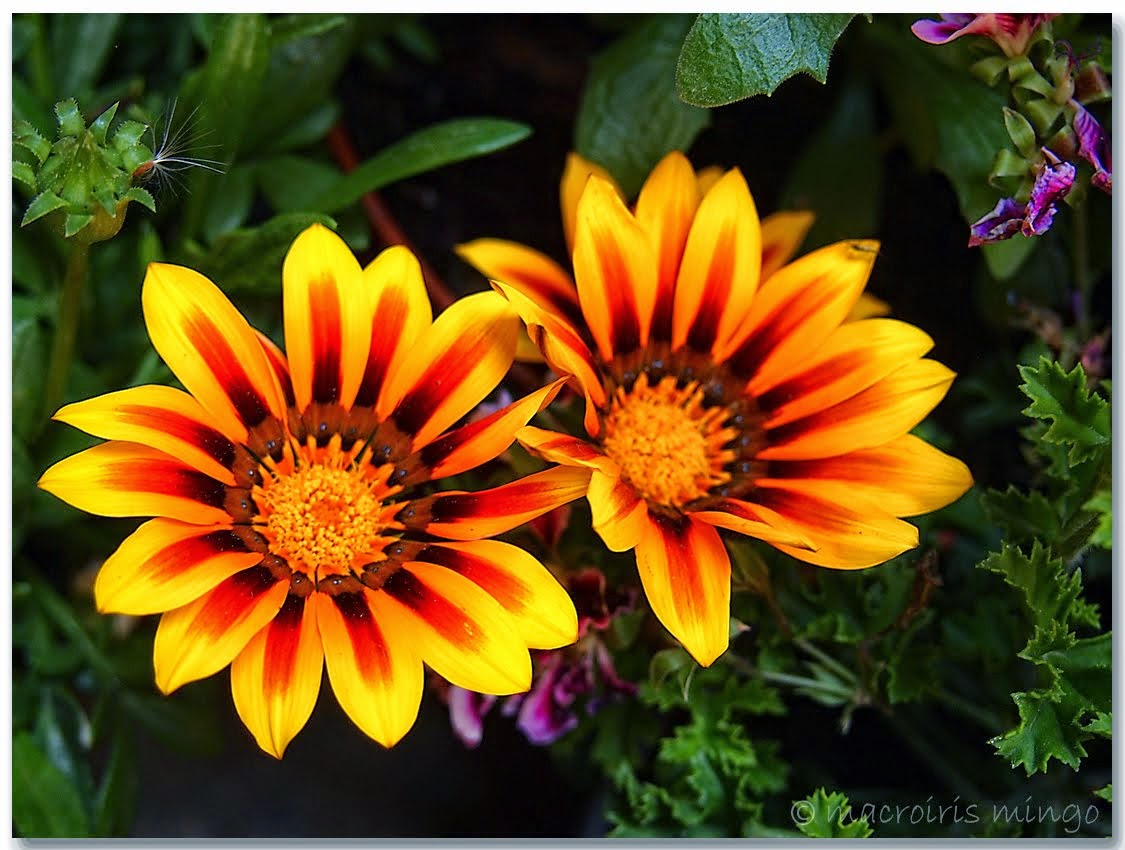

17

In [17]:
image_path = images[random.randint(0, len(images)-1)]
image = Image.open(data_dir + image_path)

serialArduino = serial.Serial("/dev/ttyACM0", 9600)



tensor = transform(image)
tensor = tensor.to(device)
tensor = tensor.reshape(1,3,506,506)


salida = model(tensor)

_, pred = torch.max(salida.data, 1)
y_pred_name = [names[pred]]

print(y_pred_name)
display(image)

serialArduino.write(y_pred_name[0].encode('utf8'))
#serialArduino.close()

In [11]:
import serial
import csv
import time

# Configurar el puerto serial
serialArduino = serial.Serial(port='/dev/ttyACM0', baudrate=9600, timeout=1)

# Esperar a que el puerto esté listo
time.sleep(2)

# Abrir un archivo CSV para guardar los datos
with open('datos_sensores.csv', mode='w+', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Dispositivo','Tiempo', 'Humedad', 'Luz'])  # Encabezados del CSV
    device = 1

    try:
        print("Leyendo datos desde el puerto serial...")
        while True:
            # Leer dos líneas consecutivas (humedad y luz)
            humedad = serialArduino.readline().decode('utf-8').strip()
            luz = serialArduino.readline().decode('utf-8').strip()
            
            # Verificar que ambas lecturas sean válidas
            if humedad and luz:
                try:
                    humedad = float(humedad)  # Convertir a número
                    luz = float(luz)          # Convertir a número
                    tiempo = time.time()      # Obtener el tiempo actual
                    print(f"Tiempo: {tiempo}, Humedad: {humedad}, Luz: {luz}")
                    
                    # Guardar en el archivo CSV
                    writer.writerow([device, tiempo, humedad, luz])
                except ValueError:
                    print(f"Datos inválidos: humedad='{humedad}', luz='{luz}'")
    except KeyboardInterrupt:
        print("Finalizando lectura...")
    finally:
        # Cerrar el puerto serial
        serialArduino.close()


Leyendo datos desde el puerto serial...
Tiempo: 1735181737.6581547, Humedad: 598.0, Luz: 158.0
Tiempo: 1735181737.6582055, Humedad: 598.0, Luz: 159.0
Tiempo: 1735181737.6582377, Humedad: 590.0, Luz: 159.0
Tiempo: 1735181737.6582685, Humedad: 597.0, Luz: 158.0
Tiempo: 1735181737.658299, Humedad: 600.0, Luz: 159.0
Tiempo: 1735181737.6583292, Humedad: 594.0, Luz: 158.0
Tiempo: 1735181737.8067381, Humedad: 592.0, Luz: 158.0
Tiempo: 1735181738.1139143, Humedad: 596.0, Luz: 159.0
Tiempo: 1735181738.425161, Humedad: 592.0, Luz: 158.0
Tiempo: 1735181738.7323472, Humedad: 589.0, Luz: 158.0
Tiempo: 1735181739.039615, Humedad: 589.0, Luz: 158.0
Tiempo: 1735181739.351034, Humedad: 594.0, Luz: 158.0
Tiempo: 1735181739.6582148, Humedad: 594.0, Luz: 158.0
Tiempo: 1735181739.9654393, Humedad: 595.0, Luz: 157.0
Tiempo: 1735181740.2766075, Humedad: 596.0, Luz: 156.0
Tiempo: 1735181740.5839453, Humedad: 588.0, Luz: 153.0
Tiempo: 1735181740.8909564, Humedad: 578.0, Luz: 152.0
Tiempo: 1735181741.2021914, H